<a href="https://colab.research.google.com/github/ssv273/computer_vision/blob/master/HW_03_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

import warnings
warnings.filterwarnings("ignore")

# Загрузка датасета Food-101

In [0]:
# tfds.disable_progress_bar()
(train_ds, test_ds), ds_info = tfds.load(
    'food101', 
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]']
)

# Визуализация датасета Food-101

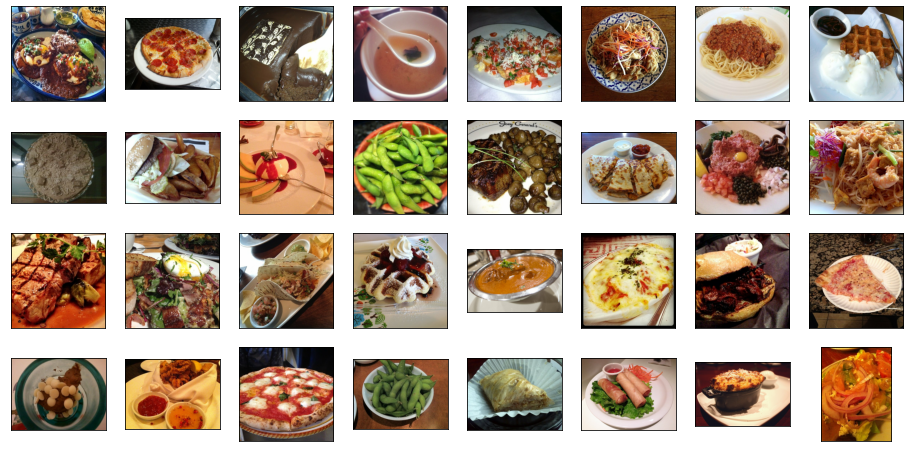

In [4]:
some_samples = [x[0] for x in iter(train_ds.take(32))]

fig = plt.figure(figsize=(16,8))
for i in range(len(some_samples)):
  ax = fig.add_subplot(4, 8, i + 1)
  ax.imshow(some_samples[i])
  plt.xticks([]), plt.yticks([])
plt.show()

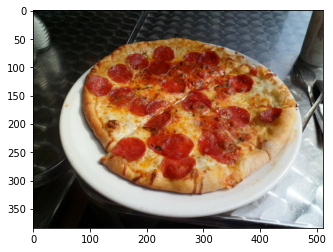

In [5]:
plt.imshow(some_samples[1])

In [6]:
tf.data.experimental.cardinality(train_ds)

<tf.Tensor: shape=(), dtype=int64, numpy=68175>

# Создание пайплайна данных

In [0]:
def convert(image, label):
  image = tf.cast(image, tf.float32) / 255
  return tf.image.resize(image, (INP_SIZE, INP_SIZE)), label

def augment(image,label):
  image,label = convert(image, label)
  image = tf.image.random_flip_left_right(image)           # Random flip
  image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
  image = tf.image.random_flip_up_down(image)              # Random flip

  return image,label

In [0]:
BATCH_SIZE = 32
INP_SIZE = 224

In [0]:
train_ds = train_ds.map(augment)

# Посмотрим на аугментированные изображения

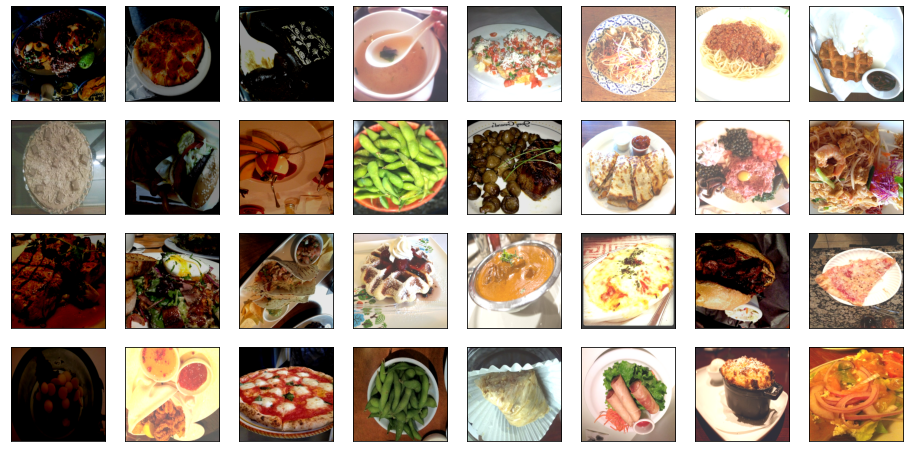

In [10]:
some_samples = [x[0] for x in iter(train_ds.take(32))]

fig = plt.figure(figsize=(16,8))
for i in range(len(some_samples)):
  ax = fig.add_subplot(4, 8, i + 1)
  ax.imshow(some_samples[i])
  plt.xticks([]), plt.yticks([])
plt.show()

In [11]:
tf.data.experimental.cardinality(train_ds)

<tf.Tensor: shape=(), dtype=int64, numpy=68175>

In [0]:
train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.shuffle(buffer_size=1000)
test_ds = test_ds.map(convert)
test_ds = test_ds.batch(128, drop_remainder=True)

# Подготовка модели CNN

In [13]:
EXP_NAME = 'transfer'
base_model = tf.keras.applications.ResNet50(
    input_shape=(INP_SIZE, INP_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable=True     # fine tuning (доработка) весов предобученной модели

94773248/94765736 [==============================] - 1s 0us/step


In [0]:
model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(101, activation='softmax')                     
])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               206949    
Total params: 23,794,661
Trainable params: 23,741,541
Non-trainable params: 53,120
_________________________________________________________________


# Подготовка к обучению

In [0]:
NUM_EPOCHS = 10

In [0]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)

# loss = tf.losses.SparseCategoricalCrossentropy()

model.compile(optimizer=optimizer,
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir = 'logs/my_model_plus_aug',
    write_graph=False, 
    update_freq=100,
    profile_batch=0
)

# Обучение модели

In [18]:
%%time

history = model.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_data=test_ds,
    callbacks=[tensorboard_callback]
)

Epoch 1/10
2130/2130 [==============================] - 532s 250ms/step - loss: 3.4732 - accuracy: 0.1895 - val_loss: 3.0861 - val_accuracy: 0.2525
Epoch 2/10
2130/2130 [==============================] - 528s 248ms/step - loss: 2.3401 - accuracy: 0.4147 - val_loss: 2.7112 - val_accuracy: 0.3516
Epoch 3/10
2130/2130 [==============================] - 528s 248ms/step - loss: 1.8955 - accuracy: 0.5170 - val_loss: 2.3962 - val_accuracy: 0.4186
Epoch 4/10
2130/2130 [==============================] - 529s 248ms/step - loss: 1.6319 - accuracy: 0.5755 - val_loss: 2.1808 - val_accuracy: 0.4623
Epoch 5/10
2130/2130 [==============================] - 531s 249ms/step - loss: 1.4215 - accuracy: 0.6260 - val_loss: 1.7776 - val_accuracy: 0.5494
Epoch 6/10
2130/2130 [==============================] - 531s 249ms/step - loss: 1.2489 - accuracy: 0.6659 - val_loss: 2.1836 - val_accuracy: 0.4811
Epoch 7/10
2130/2130 [==============================] - 533s 250ms/step - loss: 1.1010 - accuracy: 0.7008 - val_

# Оценка качества модели

In [19]:
%%time

model.evaluate(test_ds)

59/59 [==============================] - 12s 210ms/step - loss: 1.7497 - accuracy: 0.5855
CPU times: user 35.9 s, sys: 5.28 s, total: 41.1 s
Wall time: 13.7 s


[1.7497018575668335, 0.585540235042572]

# TensorBoard

In [20]:
%load_ext tensorboard
%tensorboard --logdir logs

<IPython.core.display.Javascript object>

# Запуск предсказания на своем изображении

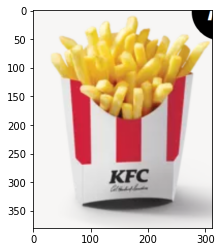

In [21]:
import imageio
from skimage.transform import resize

def prepare_image(img):
  img = img.astype(np.float32) / 255
  img = resize(img, (INP_SIZE, INP_SIZE), order=3, mode='reflect', anti_aliasing=True)
  return img.astype(np.float32)

# if 1:
#   !wget https://github.com/ssv273/computer_vision/blob/master/cat1.png

img = imageio.imread('free.png',
                     pilmode='RGB'
                     )

plt.imshow(img)

img = prepare_image(img)

In [0]:
pred = model(img[None, ...], training=False)

In [0]:
pred_label = pred.numpy().argmax()

In [31]:
print('Prediction: {}'.format(ds_info.features['label'].int2str(pred_label)))

Prediction: french_fries
